# Making Your Own Weighted Difference Map 

A common methodology for investigating structural changes in change-of-state crystallography experiments is using difference maps between structure factor amplitudes collected with and without a perturbation. These $(|F_{On}| - |F_{Off}|)$ maps may be noisy due to systematic errors or scaling artifacts, and have historically been weighted based on the magnitude of the difference signal and/or the error estimates associated with the measured values.  

In the previous notebook, we used PYP data to make a weighted difference map. This notebook is a template to allow you to make your own difference map using your own data.

<div class="alert alert-block alert-info">
<b>Note:</b> To run this, you will be uploading MTZ files to this notebook. Although these files will be on a server temporarily, they are deleted once this notebook is closed.
</div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
import numpy as np

In [2]:
import reciprocalspaceship as rs

In [3]:
print(rs.__version__)

1.0.7


---
### Load `On` and `Off` DataSets  

You will specify `On` and `Off` MTZ files that are uploaded to this notebook. It is assumed that there is exactly one column in each MTZ containing structure factors and one column containing uncertainties in those structure factors. If there are multiple columns with each data type, only the first will be used.

In [4]:
import ipywidgets as widgets
from IPython.display import display
import io

print("On MTZ:")
uploader_on = widgets.FileUpload(accept=".mtz", multiple=False)
display(uploader_on)

print("Off MTZ:")
uploader_off = widgets.FileUpload(accept=".mtz", multiple=False)
display(uploader_off)

On MTZ:


FileUpload(value=(), accept='.mtz', description='Upload')

Off MTZ:


FileUpload(value=(), accept='.mtz', description='Upload')

In [5]:
def read_uploadedFile(uploadedFile):
    """Use temporary file to read uploaded data"""
    from tempfile import NamedTemporaryFile
    upload = NamedTemporaryFile(suffix="mtz")
    upload.write(uploadedFile.data[0])
    mtz = rs.read_mtz(upload.name)
    upload.close()
    return mtz

In [6]:
mtz_on  = read_uploadedFile(uploader_on)
mtz_off = read_uploadedFile(uploader_off)

AttributeError: 'FileUpload' object has no attribute 'data'

The on file looks like this:

In [7]:
mtz_on

NameError: name 'mtz_on' is not defined

In [8]:
def subset_to_F_and_SigF(mtz):
    F_column = [ l for l in mtz.columns if mtz[l].dtype.mtztype == "F"]
    SigF_column = [ l for l in mtz.columns if mtz[l].dtype.mtztype == "Q"]
    return mtz[[F_column[0], SigF_column[0]]]

In [9]:
mtz_on = subset_to_F_and_SigF(mtz_on)
mtz_off = subset_to_F_and_SigF(mtz_off)

NameError: name 'mtz_on' is not defined

Since difference maps can only be made with Fourier magnitudes that were measured in both datasets, we will subset the datasets to their common Miller indices.

In [10]:
diff = mtz_off.merge(mtz_on, left_index=True, right_index=True, suffixes=("_off", "_on"))

NameError: name 'mtz_off' is not defined

In [11]:
diff.head()

NameError: name 'diff' is not defined

---
### Compute Difference Map Coefficients and Errors  

We will compute $(|F_{On}| - |F_{Off}|)$ for use as the coefficients of the difference map, and we will propagate the uncertainties in quadrature. These propagated uncertainties will be used when computing weights for each Miller index.

In [12]:
diff["DF"] = (diff["F_on"] - diff["F_off"]).astype("SFAmplitude")
diff["SigDF"] = np.sqrt(diff["SigF_on"]**2 + diff["SigF_off"]**2).astype("Stddev")

NameError: name 'diff' is not defined

---
### Compute Difference Map Weights  

There are several weighting schemes that have been used to produce time-resolved difference maps. Many of them take the form below, involving a term based on the uncertainty in the difference structure factor amplitude ($\sigma_{\Delta F}$), and optionally, a scale term based on the the magnitude of the observed $\Delta F$. With $\alpha=0$, these weights take the form employed in [Ursby and Bourgeois, **Acta Cryst** (1997)](https://scripts.iucr.org/cgi-bin/paper?he0183). On the other hand, [Šrajer *et al*, **Biochemistry** (2001)](https://pubs.acs.org/doi/10.1021/bi010715u) employed weights with $\alpha=1$ in order to decrease the impact of abnormally large values of $\Delta F$ that may have erroneously small uncertainties. Finally, other weighting schemes have employed intermediate values of $\alpha$ ([Hekstra *et al*, **Nature** (2016)](https://www.nature.com/articles/nature20571)). 

\begin{equation}
w = \left(1 + \frac{\sigma_{\Delta F}^2}{\overline{\sigma_{\Delta F}^2}} + \alpha\frac{|\Delta F|^2}{\overline{ |\Delta F|^2 }} \right)^{-1}
\end{equation}  

For illustration purposes, we will compute weights with $\alpha=0.05$.

In [13]:
def compute_weights(df, sigdf, alpha=0):
    """
    Compute weights for each structure factor based on deltaF and its uncertainty
    """
    w = (1 + (sigdf**2 / (sigdf**2).mean()) + alpha*(df**2 / (df**2).mean()))
    return w**-1

In [14]:
diff["W"] = compute_weights(diff["DF"], diff["SigDF"], alpha=0.00)
diff["W"] = diff["W"].astype("W")

NameError: name 'diff' is not defined

Let's visualize the weights relative to the magnitude of $\Delta F$ and the signal-to-noise ratio in order to understand how they will affect different structure factors.

NameError: name 'diff' is not defined

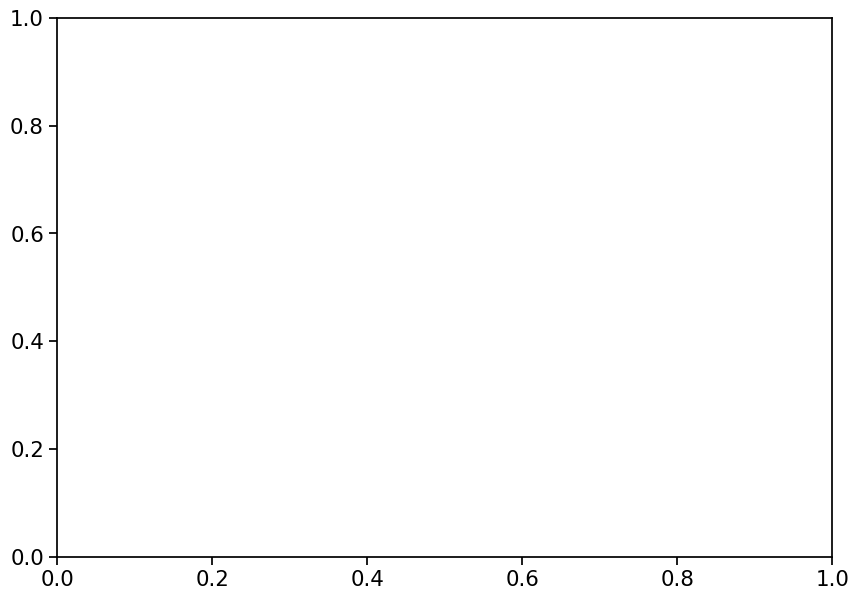

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
pts = ax.scatter(diff.DF, diff.DF.abs()/diff.SigDF, c=diff.W)
x1, x2 = plt.gca().get_xlim()
ax.set_xlim(x1-0.5, x2+0.5)
ax.set_xlabel(r"$\Delta F$")
ax.set_ylabel(r"$\frac{\left| \Delta F \right|}{\sigma_{\Delta F}}$")

# Inset
axins = ax.inset_axes([0.6, 0.6, 0.37, 0.37])
axins.scatter(diff.DF, diff.DF.abs()/diff.SigDF, c=diff.W)
y1, y2 = 0, 10
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins)

fig.colorbar(pts, label="Weight")
plt.show()

As seen in the above plot, difference Fourier coefficients with low signal-to-noise ratios (large $\sigma_{\Delta F}$ relative to $|\Delta F|$) are assigned lower weight. Difference Fourier coefficients with large amplitude are also assigned lower weight.

---
### Phasing the Difference Map

We have our difference Fourier amplitudes and weights, so we just need phases in order to make a difference map. We will use the phases from an uploaded MTZ file -- this should correspond to an isomorphous refined structure for the system of interest. If a column named `PH2FOFCWT` is defined, it is used. Otherwise, the first column of phases is used.

In [16]:
print("Reference MTZ with Phases:")
uploader_ref = widgets.FileUpload(accept=".mtz", multiple=False)
display(uploader_ref)

Reference MTZ with Phases:


FileUpload(value=(), accept='.mtz', description='Upload')

In [17]:
mtz_ref = read_uploadedFile(uploader_ref)

AttributeError: 'FileUpload' object has no attribute 'data'

In [18]:
phases = mtz_ref.get_phase_keys()
if "PH2FOFCWT" in phases:
    phi = "PH2FOFCWT"
else:
    phi = phases[0]

NameError: name 'mtz_ref' is not defined

In [19]:
diff = diff.merge(mtz_ref[phi], left_index=True, right_index=True)

NameError: name 'diff' is not defined

In [20]:
diff

NameError: name 'diff' is not defined

The object `diff` can now be written to an MTZ file and downloaded to view offline in your GUI of choice -- we will first make a "download" button.

In [21]:
import base64
import hashlib
from typing import Callable

import ipywidgets
from IPython.display import HTML


class DownloadButton(ipywidgets.Button):
    """Download button with dynamic content

    The content is generated using a callback when the button is clicked.
    """

    def __init__(self, filename: str, contents: Callable[[], str], **kwargs):
        super(DownloadButton, self).__init__(**kwargs)
        self.filename = filename
        self.contents = contents
        self.on_click(self.__on_click)

    def __on_click(self, b):
        contents: bytes = self.contents()
        b64 = base64.encodebytes(contents)
        payload = b64.decode()
        digest = hashlib.md5(contents).hexdigest()  # bypass browser cache
        id = f'dl_{digest}'

        display(HTML(f"""
<html>
<body>
<a id="{id}" download="{self.filename}" href="data:text/csv;base64,{payload}" download>
</a>

<script>
(function download() {{
document.getElementById('{id}').click();
}})()
</script>

</body>
</html>
"""))

def getDiffMap(mtz):
    from tempfile import NamedTemporaryFile
    from io import BytesIO
    download = NamedTemporaryFile(suffix="mtz")
    mtz.write_mtz(download.name)
    with open(download.name, 'rb') as fh:
        buf = BytesIO(fh.read())
    download.close()
    return buf.getvalue()

DownloadButton(filename='diffmap.mtz', contents=lambda: getDiffMap(diff), description='download')

DownloadButton(description='download', style=ButtonStyle())

Good luck with your weighted difference map!